# Определение числа на изображении

In [105]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier


## Анализ требований

> Распознавание чисел на изображениях — это задача многоклассовой классификации. В качестве объекта, для которого необходимо предсказать класс, выступает изображение. Возможных классов столько, сколько в данных представлено чисел, которые необходимо научиться распознавать.
В качестве данных для решения задачи будут использоваться изображения из базы данных MNIST — классического набора данных для создания и проверки качества работы алгоритмов компьютерного зрения.

MNIST состоит из чёрно-белых изображений рукописных цифр. В базе представлены изображения цифр от 0
 до 9
. Каждое изображение имеет разрешение 28×28
 пикселей.

В данных, которые будут использоваться для решения задачи, представлено 42 000
 изображений. Это подмножество всех данных, доступных в MNIST.


План проекта:
1. Исследовательский анализ данных.
2. Подготовка факторов.
3. Создание модели.
4. Оценка качества модели.

Знакомство с данными

In [106]:
images_data = pd.read_csv('images.csv')
images_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Изображение размером 28×28 представляется в виде последовательности из 784 чисел — по одному числу на каждый пиксель изображения. Каждое число находится в диапазоне от 0 до 255. Чем больше число, тем выше интенсивность пикселя. Нулевой интенсивности соответствует абсолютно чёрный пиксель, максимальной — абсолютно белый.

Пример изображения цифры 4, взятого из данных:

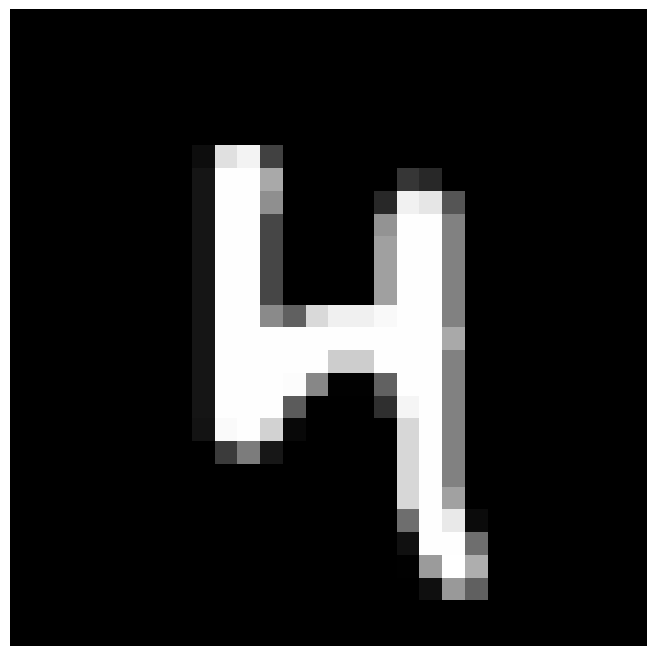

Каждое изображение представляется в виде строчки в таблице images.csv. В таблице есть колонки pixel0, pixel1 и так далее до pixel783, каждая из которых соответствует значению конкретного пикселя изображения. Также в таблице есть колонка label, в которой находится информация о том, какая цифра представлена на изображении.

## Иследовательский анализ данных

In [107]:
data = images_data.values
image_matrix = data[8, 1:].reshape(28, 28)

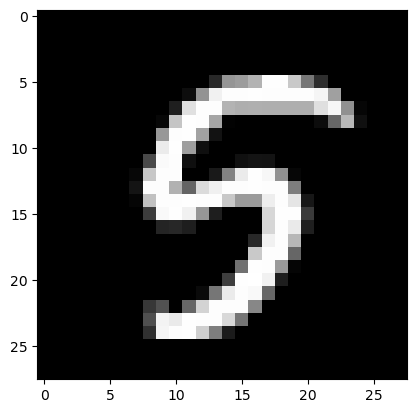

In [108]:
plt.imshow(image_matrix, cmap='gray', vmin=0, vmax=255)

Попробуем проанализировать, какие цифры похожи друг на друга, для этого выведем таблицу 10 на 9 от 0 до 9 по 9 штук в каждой строке.

In [109]:
def vector_to_image(vector, image_size=(28,28)):
    return vector[1:].reshape(image_size)

def image_grid(images, grid_size=(10, 9), image_size=(28, 28)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15,15))
    for i in range(grid_size[0]):
        mas = data_number(images, i)
        for j, vector in enumerate(mas):
            img = vector_to_image(vector, image_size)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

def data_number(images, n):
    mas = []
    for i, j in enumerate(images):
        if len(mas) == 9:
            break
        if j[0] == n:
            mas.append(j)
    return mas
            
        
        
        


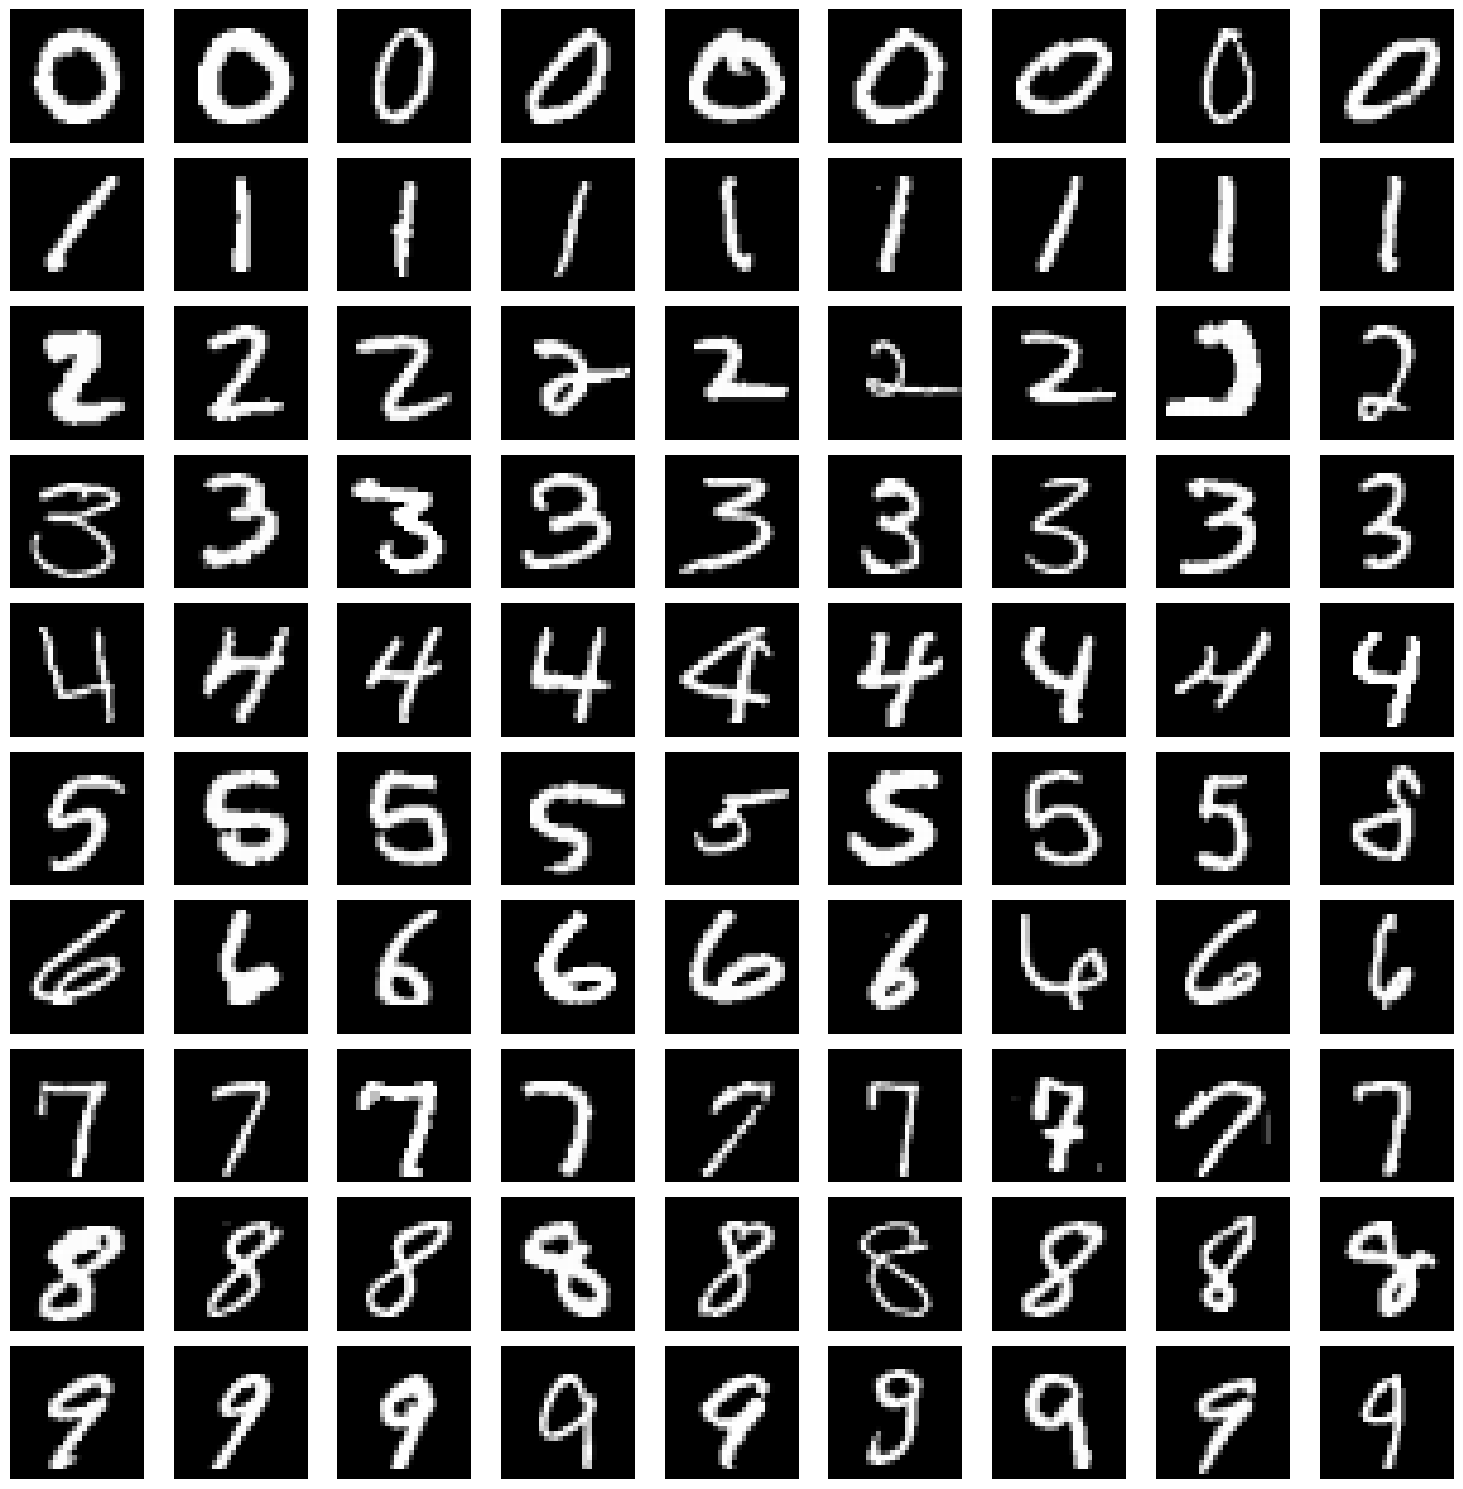

In [110]:
image_grid(data)

По таблице, можно судить, что модели будет тяжело различать 5, потому что они похожи на 6, а некоторые вообще на 9. Также можно предположить, что кто-то пишет цифру 0 с закарючкой сверху или снизу, что будет похоже на 6 или 9. Также очевидно, что некоторые цифры вообще на них не похожи, пример в строке с 4. Т.е у нас явно будут такие изображения, на которых даже человек не сможет понять, что это за цифра. От таких данных у нас будет добавляться ошибка

<Axes: >

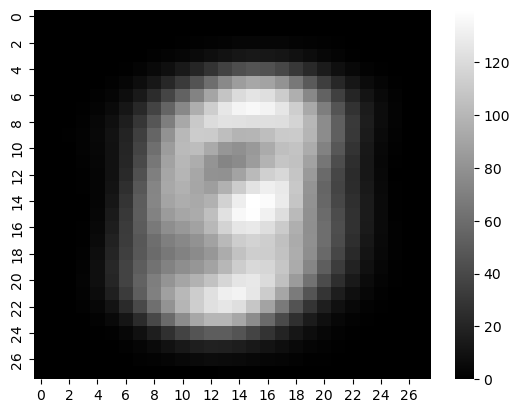

In [111]:
heatmap_data = images_data.mean().values[1:].reshape(28, 28)
sns.heatmap(heatmap_data, cmap='gray')

Анализ данных показывает, что отдельные пиксели в изображениях используются с разной интенсивностью. Чтобы наглядно в этом убедиться, можно визуализировать распределение пикселей с помощью следующих подходов:
Тепловая карта средних значений:
1. Показывает, какие области изображений используются чаще всего
2. Вычисляется как среднее значение каждого пикселя по всем изображениям
3. Дает общее представление о структуре данных

Тепловая карта стандартных отклонений:
1. Демонстрирует степень вариативности значений пикселей
2. Позволяет выявить наиболее изменчивые области изображений
3. Рассчитывается с помощью функции std()

<Axes: >

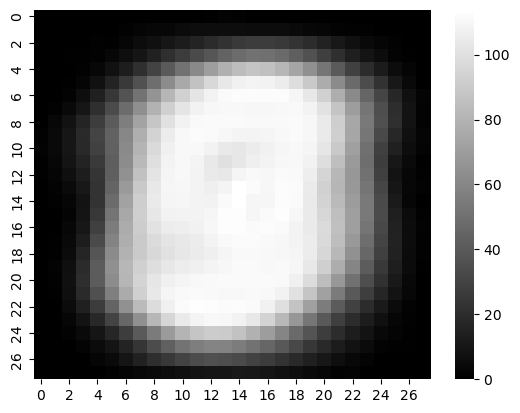

In [112]:
heatmap_data = images_data.std().values[1:].reshape(28, 28)
sns.heatmap(heatmap_data, cmap='gray')

## Подготовка данных

Для этого можно воспользоваться встроенными в sklearn объектами для отбора факторов. В частности, в библиотеке реализован подход, который убирает из данных колонки, квадрат разброса которых не превышает заданного значения

In [113]:
X = images_data.drop('label', axis=1)
y = images_data['label']

In [114]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [115]:
selector = VarianceThreshold(threshold=0)

In [116]:
selector.fit(X_train)
useful_factors = selector.get_feature_names_out()

X_train = X_train[useful_factors]
X_test = X_test[useful_factors]

## Создание модели

In [163]:
forest = RandomForestClassifier(n_estimators=1000,
                                max_depth=12,
                                criterion='gini',
                                min_samples_leaf=15,
                                random_state=42)
forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=12, min_samples_leaf=15, n_estimators=1000,
                       random_state=42)

In [164]:
y_train_pred = forest.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3269
           1       0.98      0.98      0.98      3765
           2       0.96      0.96      0.96      3336
           3       0.96      0.95      0.95      3500
           4       0.96      0.97      0.96      3256
           5       0.98      0.96      0.97      3030
           6       0.97      0.98      0.98      3333
           7       0.97      0.96      0.96      3536
           8       0.95      0.95      0.95      3239
           9       0.94      0.94      0.94      3336

    accuracy                           0.96     33600
   macro avg       0.96      0.96      0.96     33600
weighted avg       0.96      0.96      0.96     33600



In [165]:
X_err = X_train[y_train_pred != y_train]
y_err = y_train[y_train_pred != y_train]


In [166]:
X_err_copy = X_err.copy(deep=True)

In [167]:
X_err_copy['y'] = y_err
X_err_copy['y_pred'] = y_train_pred[y_train_pred != y_train]  

In [168]:
X_err_copy.groupby(['y','y_pred'], as_index=False).agg({'pixel200': 'count'}).sort_values('pixel200', ascending=False)

,y,y_pred,pixel200
40,4,9,64
75,9,3,51
62,7,9,51
25,3,2,49
58,7,2,38
...,...,...,...
35,4,3,1
36,4,5,1
10,1,5,1
1,0,3,1


In [169]:
X_err_copy['y_pred'].value_counts()

y_pred
9    197
8    148
2    146
3    143
4    117
7    110
6    102
1     94
0     76
5     69
Name: count, dtype: int64

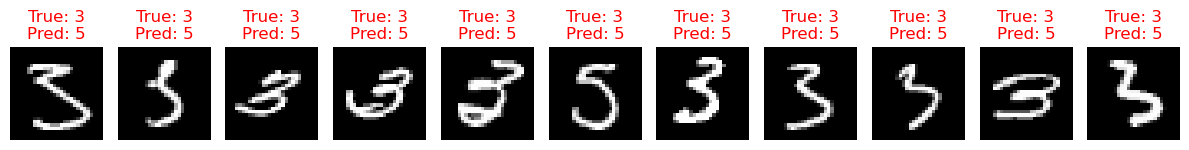

In [170]:
fig, axs = plt.subplots(1, 11, figsize=(12,10), sharex=True, sharey=True)

# Фильтрация ошибок 3 → 5
df = X_err_copy[(X_err_copy['y'] == 3) & (X_err_copy['y_pred'] == 5)] \
    .drop(columns=['y_pred', 'y'])

# Ограничиваем количество изображений 11
df = df.head(11)  # Берем только первые 11 строк

for image_n, (ind, image_row) in enumerate(df.iterrows()):
    # Получаем индексы пикселей из названий столбцов
    inds_of_pixels = [int(x[5:]) for x in df.columns]
    
    # Создаем изображение (заполняем 0 отсутствующие пиксели)
    image = np.array([image_row[f'pixel{i}'] if i in inds_of_pixels else 0 
                     for i in range(784)])
    
    # Отображаем изображение
    axs[image_n].imshow(image.reshape(28, 28), cmap='gray')
    axs[image_n].set_title(f"True: 3\nPred: 5", color='red')
    axs[image_n].axis('off')

# Скрываем неиспользованные subplots
for i in range(len(df), 11):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

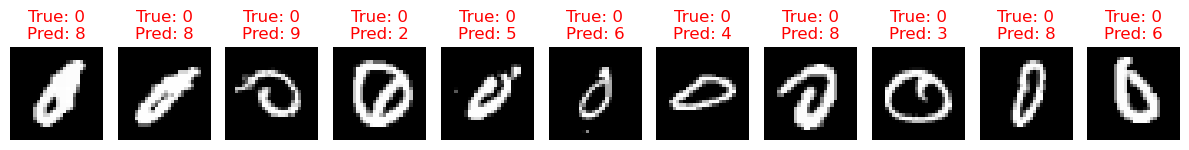

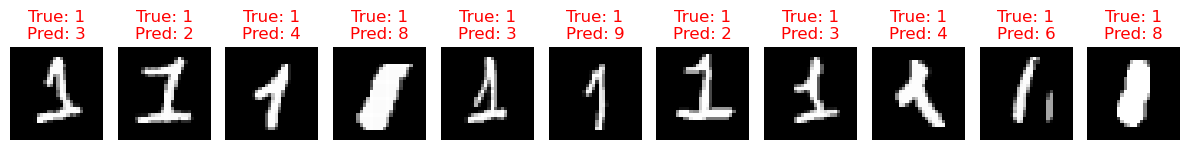

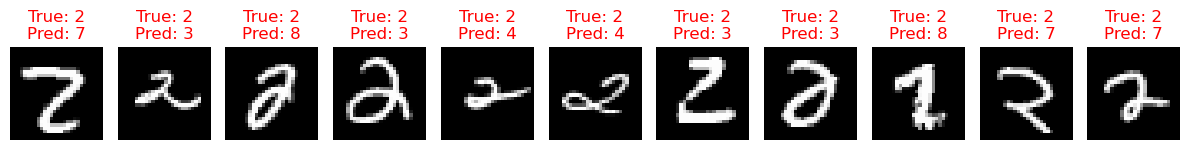

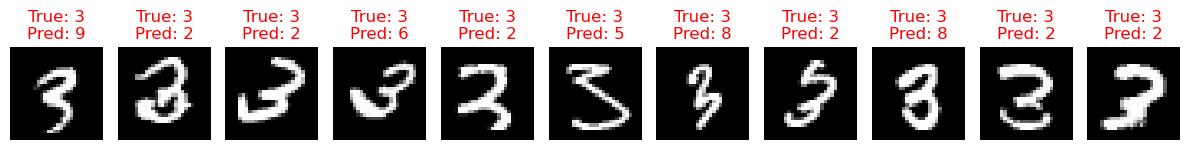

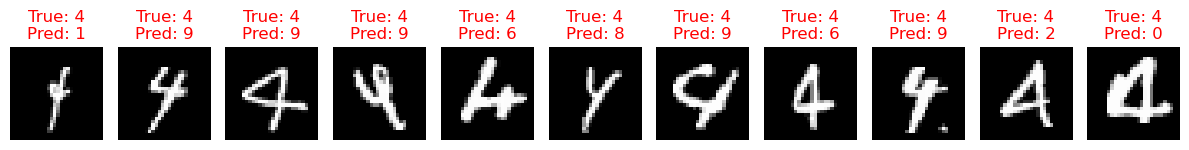

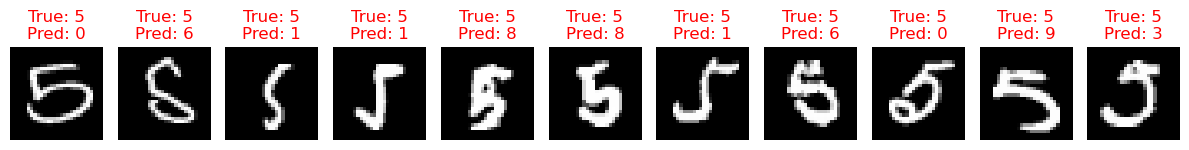

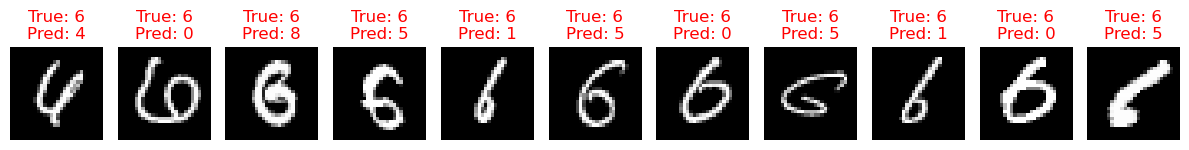

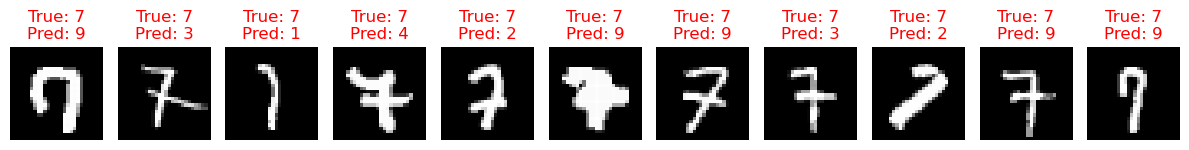

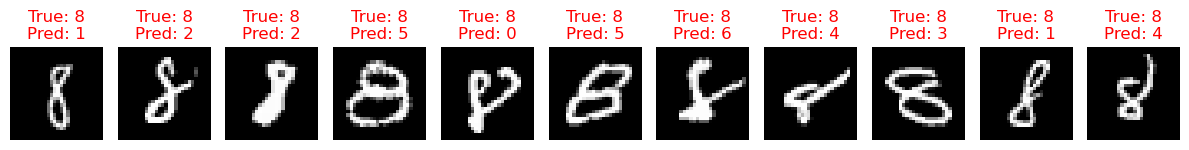

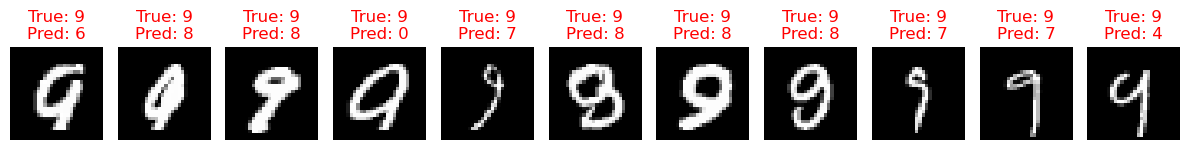

In [171]:
for n in range(10):
    fig, axs = plt.subplots(1, 11, figsize=(12, 10), sharex=True, sharey=True)

    # Фильтрация ошибок 3 → 5
    df = X_err_copy[(X_err_copy['y'] == n)] \
        .drop(columns=['y_pred', 'y'])
    y_pred = X_err_copy['y_pred']
    # Ограничиваем количество изображений 11
    df = df.head(11)  # Берем только первые 11 строк

    for image_n, (ind, image_row) in enumerate(df.iterrows()):
        # Получаем индексы пикселей из названий столбцов
        inds_of_pixels = [int(x[5:]) for x in df.columns]
        
        # Создаем изображение (заполняем 0 отсутствующие пиксели)
        image = np.array([image_row[f'pixel{i}'] if i in inds_of_pixels else 0 
                        for i in range(784)])
        
        # Отображаем изображение
        axs[image_n].imshow(image.reshape(28, 28), cmap='gray')
        axs[image_n].set_title(f"True: {n}\nPred: {y_pred[ind]}", color='red')
        axs[image_n].axis('off')

    # Скрываем неиспользованные subplots
    for i in range(len(df), 11):
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

Среди наших ошибок есть как ошибки, так и плохо написанные цифры, которые явно не похожи на себя. Например 7, написана как 1, поэтому модель еее за 1 и приняла

## Оценка качества

In [172]:
y_test_pred = forest.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       863
           1       0.97      0.98      0.98       919
           2       0.96      0.94      0.95       841
           3       0.93      0.92      0.93       851
           4       0.95      0.94      0.95       816
           5       0.95      0.93      0.94       765
           6       0.96      0.98      0.97       804
           7       0.95      0.94      0.95       865
           8       0.93      0.93      0.93       824
           9       0.89      0.93      0.91       852

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



Модель показывает отличный результат, однако обучается она около 2 минут.
Я подобрал довольно высокий параметр количества деревьев в ансабле, от чего метрика увеличилась, по сравнению с 500, но и начала занимать времени в 2 раза больше. Чтобы понять какие параметры лучше всего подходят, можно попробовать их найти. Грид ресерч использовать не советую, потому что если наша модель обучается по минуте, то грид будет искать оптимальный вариант будет искаться намного дольше. Нужно попробовать использовать продвинутые методы нахождения гиперпараметров. Но, это тоже не нужно, так как модель выдает очень высокий результат, только если биться за процент